In [1]:
# whether this notebook is on Google Colaboratory
try:
    import google.colab
    ON_COLAB = True
except:
    ON_COLAB = False
else:
    pass
    %pip install transformers[torch] datasets evaluate ipyplot huggingface_hub
    %load_ext tensorboard
    from huggingface_hub import notebook_login
    notebook_login()

## Import

In [2]:
import os
import random

from pathlib import Path

from datasets import Image, ClassLabel, DatasetDict, Dataset, load_from_disk, load_dataset
import matplotlib.pyplot as plt

/home/toda/.venv/ml/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create id2label and label2id

In [3]:
IGNORE_INDEX = 0
id2label = {
    0: "Ignore",
    1: "Background",
    2: "Building",
    3: "Road",
    4: "Water",
    5: "Barren",
    6: "Forest",
    7: "Agricultural"
}
assert( id2label[IGNORE_INDEX] == "Ignore" )

label2id = { v: k for k, v in id2label.items() }
num_label = len(id2label)

## [Only once] Collect all data and merge them into single `DatasetDict`

In [4]:
# define function not to contaminate the namespace
def restructure_dataset(
    dataset_root_dirpath: str,
    train_ratio: float,
    val_ratio: float,
    test_ratio: float,
    shuffle_seed: int = 42,
) -> DatasetDict:
    all_image_paths = []
    all_mask_paths = []
    # Rural: 0, Urban: 1
    all_labels = []
    # ClassLabel in Hugging Face datasets format
    classlabel = ClassLabel(num_classes=2, names=["Rural", "Urban"])

    ds_root_path = Path(dataset_root_dirpath)
    for portion in ["Train", "Val"]:
        for region in ["Rural", "Urban"]:
            image_paths = list(ds_root_path.glob(
                os.path.join(portion, region, "images_png", "*.png")
            ))
            image_count = len(image_paths)
            mask_paths = list(ds_root_path.glob(
                os.path.join(portion, region, "masks_png", "*.png")
            ))
            if region == "Rural":
                labels = [0] * image_count
            else:
                labels = [1] * image_count
            assert [p.name for p in image_paths] == [p.name for p in mask_paths]

            all_image_paths += [str(p) for p in image_paths]
            all_mask_paths += [str(p) for p in mask_paths]
            all_labels += labels
            
    new_dataset = Dataset.from_dict({
        "image": all_image_paths,
        "mask": all_mask_paths,
        "label": all_labels,
    }).cast_column("image", Image()).cast_column("mask", Image()).cast_column("label", classlabel)
    new_dataset = new_dataset.shuffle(seed=shuffle_seed)
    
    train_valAndTest = new_dataset.train_test_split(
        train_size=train_ratio,
        test_size=val_ratio+test_ratio,
        stratify_by_column='label'
    )
    val_test = train_valAndTest["test"].train_test_split(
        test_size=test_ratio/(val_ratio+test_ratio),
        stratify_by_column='label'
    )
    
    return DatasetDict({
        "train": train_valAndTest["train"].remove_columns(column_names=["label"]),
        "val": val_test["train"].remove_columns(column_names=["label"]),
        "test": val_test["test"].remove_columns(column_names=["label"])
    })
    
ds_dict = restructure_dataset(
    dataset_root_dirpath="./dataset/LoveDA",
    train_ratio=0.70,
    val_ratio=0.15,
    test_ratio=0.15,
)

ds_dict.save_to_disk(
    dataset_dict_path="./dataset/LoveDA_restructured"
)

## Load dataset and apply transforms

In [4]:
if ON_COLAB:
    DATASET_IDENTIFIER = "wu-pr-gw/LoveDA_restructured"
    ds_dict = load_dataset(path=DATASET_IDENTIFIER)
else:
    DATASET_PATH = "./dataset/LoveDA_restructured"
    ds_dict = load_from_disk(dataset_path=DATASET_PATH)
print(ds_dict)

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 2933
    })
    val: Dataset({
        features: ['image', 'mask'],
        num_rows: 629
    })
    test: Dataset({
        features: ['image', 'mask'],
        num_rows: 629
    })
})


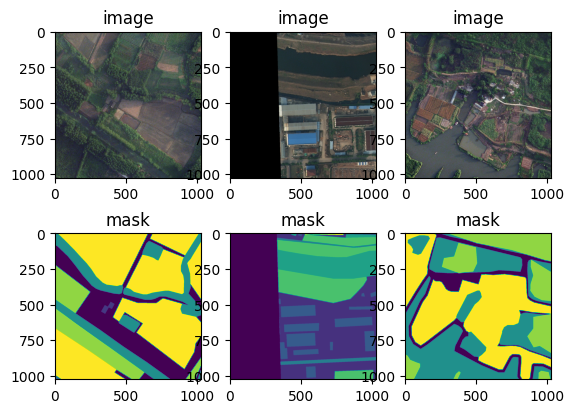

In [6]:
# define function not to contaminate namespace
def show_some_examples():
    rnd_idx = random.randint(0, 628)

    fig, ax = plt.subplots(nrows=2, ncols=3)
    samples = []
    for split in ["train", "val", "test"]:
        samples.append(
            (
                ds_dict[split][rnd_idx]["image"],
                ds_dict[split][rnd_idx]["mask"],
            )
        )
    
    for pair_idx, (image, mask) in enumerate(samples):
        ax[0, pair_idx].set_title("image")
        ax[0, pair_idx].imshow(image)
        ax[1, pair_idx].set_title("mask")
        ax[1, pair_idx].imshow(mask)
    
    plt.show()
    
show_some_examples()

### WARNING! We should rename features to what Segformer model expects

In [7]:
for split in ["train", "val", "test"]:
    ds_dict[split] = ds_dict[split].rename_columns({
        "image": "pixel_values",
        "mask": "label",
    })

Define transforms, in order to augument training data by splitting each original image (1024x1024) into 4 parts (512x512)

In [8]:
import torchvision.transforms.functional as TF
from torchvision.transforms import ColorJitter, RandomHorizontalFlip
from transformers import SegformerFeatureExtractor

feature_extractor = SegformerFeatureExtractor()
jitter = ColorJitter(
    brightness=0.2,
    contrast=0.2,
    saturation=0.2,
    hue=0.1,
)
random_horizontal_flipper = RandomHorizontalFlip()

CROP_SIZE = 512

def train_transforms(batch):
    crop_areas = [
        (0, 0, CROP_SIZE, CROP_SIZE),  # upper-left
        (0, CROP_SIZE-1, CROP_SIZE, CROP_SIZE),  # upper-right
        (CROP_SIZE-1, 0, CROP_SIZE, CROP_SIZE),  # lower-left
        (CROP_SIZE-1, CROP_SIZE-1, CROP_SIZE, CROP_SIZE),  # lower-right
    ]
    
    cropped_images = []
    cropped_masks = []
    for entire_image, entire_mask in zip(batch["pixel_values"], batch["label"]):
        for crop_area in crop_areas:
            ### crop [raw_image & mask]
            cropped_image = TF.crop(entire_image, *crop_area)
            cropped_mask = TF.crop(entire_mask, *crop_area)
            ### randomly flip horizontally [raw_image & mask]
            if random.random() > 0.5:
                cropped_image = TF.hflip(cropped_image)
                cropped_mask = TF.hflip(cropped_mask)
            ### apply jitter with the possibility of 25% [raw_image]
            if random.random() < 0.25:
                cropped_image = jitter(cropped_image)
            
            # append this portion of image into list
            cropped_images.append(cropped_image)
            cropped_masks.append(cropped_mask)
            
    model_inputs = feature_extractor(images=cropped_images, segmentation_maps=cropped_masks)
    return model_inputs

def val_transforms(batch):
    # no need for cropping, because SegformerFeatureExtractor will process input size
    images = [image for image in batch["pixel_values"]]
    masks = [mask for mask in batch["label"]]
    model_inputs = feature_extractor(images=images, segmentation_maps=masks)
    return model_inputs

2023-07-08 22:08:40.222585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 22:08:41.001691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/toda/.venv/ml/lib/python3.8/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [9]:
ds_dict["train"].set_transform(train_transforms)
ds_dict["val"].set_transform(val_transforms)
ds_dict["test"].set_transform(val_transforms)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 2933
    })
    val: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 629
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 629
    })
})


## Prepare Segformer Model

In [10]:
from transformers import SegformerForSemanticSegmentation

pretrained_model_name = "nvidia/mit-b2"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name_or_path=pretrained_model_name,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at nvidia/mit-b2 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b2 and are newly initialized: ['decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.classifier.bias', 'decode_head.linear

## Prepare for training

In [11]:
MODEL_SAVE_DIR = "segformer-finetuned-with-LoveDA"

In [12]:
from transformers import TrainingArguments

epochs = 50
learning_rate = 0.00006
batch_size = 2

training_args = TrainingArguments(
    output_dir=MODEL_SAVE_DIR,
    learning_rate=learning_rate,
    lr_scheduler_type="linear",
    weight_decay=0.001,  # coefficient of L2 Regularizer
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    report_to="tensorboard",
)

/home/toda/.venv/ml/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Make IoU calculator for evaluation

In [13]:
import torch, evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_preds):
    with torch.no_grad():
        logits, masks = eval_preds
        logits_tensor = torch.from_numpy(logits)
        # resize the output logits to fit the size of the masks
        pred_labels = torch.nn.functional.interpolate(
            input=logits_tensor,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1).detach().cpu().numpy()
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
            predictions=pred_labels,
            references=masks,
            num_labels=num_label,
            ignore_index=IGNORE_INDEX,
            reduce_labels=feature_extractor.do_reduce_labels,
        )
        
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()
        
        metrics.update({
            f"accuracy_{id2label[idx]}": value for idx, value in enumerate(per_category_accuracy)
        })
        metrics.update({
            f"iou_{id2label[idx]}": value for idx, value in enumerate(per_category_iou)
        })
        
        return metrics
        

## Execute training

In [14]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_dict["train"],
    eval_dataset=ds_dict["val"],
    compute_metrics=compute_metrics,
)

Let's monitor training with TensorBoard

In [15]:
tensorboard_log_dir = os.path.join(MODEL_SAVE_DIR, "runs")
%tensorboard --logdir=$tensorboard_log_dir

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
trainer.train()

Evaluate the result

In [17]:
trainer.evaluate(
    eval_dataset=ds_dict["test"]
)

/home/toda/.venv/ml/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/home/toda/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'eval_loss': 0.6277254223823547,
 'eval_mean_iou': 0.5220808001579857,
 'eval_mean_accuracy': 0.7176747174722734,
 'eval_overall_accuracy': 0.7574299379371443,
 'eval_accuracy_Ignore': nan,
 'eval_accuracy_Background': 0.7385866052964004,
 'eval_accuracy_Building': 0.7360174959308529,
 'eval_accuracy_Road': 0.6901036685813214,
 'eval_accuracy_Water': 0.8179360783083665,
 'eval_accuracy_Barren': 0.4840646771242136,
 'eval_accuracy_Forest': 0.6623101590750178,
 'eval_accuracy_Agricultural': 0.8947043379897415,
 'eval_iou_Ignore': 0.0,
 'eval_iou_Background': 0.5711435097985501,
 'eval_iou_Building': 0.5668721894453863,
 'eval_iou_Road': 0.5888737692950637,
 'eval_iou_Water': 0.7390003310815076,
 'eval_iou_Barren': 0.4303431578201322,
 'eval_iou_Forest': 0.581993177433934,
 'eval_iou_Agricultural': 0.6984202663893114,
 'eval_runtime': 111.7816,
 'eval_samples_per_second': 5.627,
 'eval_steps_per_second': 1.413,
 'epoch': 50.0}

## Prediction

You can try the model by executing only the first cell of this notebook and below cells

In [1]:
id2label = {
    0: "Ignore",
    1: "Background",
    2: "Building",
    3: "Road",
    4: "Water",
    5: "Barren",
    6: "Forest",
    7: "Agricultural"
}
label2id = { v: k for k, v in id2label.items() }

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
feature_extractor = SegformerFeatureExtractor()
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name_or_path="wu-pr-gw/segformer-b2-finetuned-with-LoveDA",
    use_auth_token=True,
    id2label=id2label,
    label2id=label2id,
).to("cuda")

2023-07-10 13:49:35.724735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 13:49:36.580620: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/toda/.venv/ml/lib/python3.8/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/home/toda/.venv/ml/lib/python3.8/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


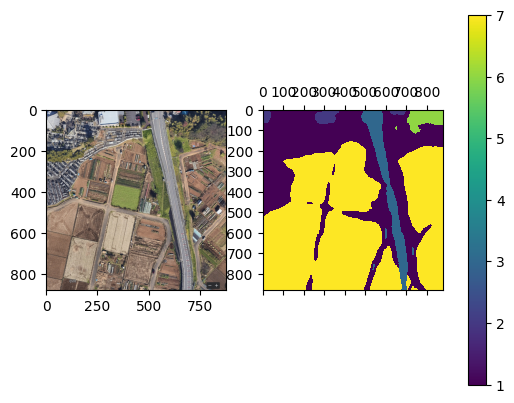

In [2]:
from PIL import Image
import torch

# specify an image put inside "/content"
image_path = "google_earth_akiruno.png"

input_image = Image.open(image_path).convert(mode="RGB")
inputs = feature_extractor(images=input_image, return_tensors="pt").to("cuda")
outputs = model(**inputs)
logits = outputs.logits

# rescale the logits to original image size
upsampled_logits = torch.nn.functional.interpolate(
    logits,
    size=input_image.size[::-1],
    mode="bilinear",
    align_corners=False,
)
# apply argmax
pred_seg = upsampled_logits.argmax(dim=1)[0]
# pred_seg = upsampled_logits[0].argsort(dim=0)[-2]
import numpy as np

# pred_seg_pil = Image.fromarray(pred_seg.cpu().numpy().astype(np.uint8))
# # draw half-transparent mask on the raw image
# pred_seg_pil.putalpha(alpha=128)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(input_image)
axmask = ax[1].matshow(pred_seg.cpu().numpy())
fig.colorbar(axmask, ax=ax)
plt.show()

upload the model

In [ ]:
# kwargs = {
#     "tags": ["vision", "image-segmentation"],
#     "finetuned_from": "nvidia/mit-b2",
#     "dataset": "wu-pr-gw/LoveDA_restructured",
# }

# feature_extractor.push_to_hub(repo_id="wu-pr-gw/segformer-b2-finetuned-with-LoveDA")

# model.push_to_hub(
#     repo_id="wu-pr-gw/segformer-b2-finetuned-with-LoveDA",
#     private=True,
#     **kwargs
# )